In [221]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

***

**NOTA:** En este notebook he decidido no incluir a las funciones de activación sigmoide y tanh, debido a que "relu" y "leaky relu" tuvieron un mejor desempeño, es por esto que para las capas ocultas solo se hace uso de estas dos funciones, mientras que para la capa de salida (y debido a que la clasificación es multi-clase), haremos uso exclusivamente de la función de activación softmax.

***

In [222]:
from mnist import MNIST

Datos_MNIST = MNIST("MNIST_dataset") # Cargamos la totalidad de datos de MNIST.

imagenes_entrenamiento, etiquetas_entrenamiento = Datos_MNIST.load_training() # Cargando datos de entrenamiento.
imagenes_testeo, etiquetas_testeo = Datos_MNIST.load_testing() # Cargando datos para probar nuestra red una vez se halla entrenado.

imagenes_entrenamiento, etiquetas_entrenamiento = np.asarray(imagenes_entrenamiento), np.asarray(etiquetas_entrenamiento)
imagenes_testeo, etiquetas_testeo = np.asarray(imagenes_testeo), np.asarray(etiquetas_testeo)

imagenes_entrenamiento = (imagenes_entrenamiento/imagenes_entrenamiento.max()).astype("float64")
imagenes_testeo = (imagenes_testeo/imagenes_testeo.max()).astype("float64")

In [223]:
def one_hot_encode (etiquetas):
    """Esta función nos arroja un vector one_hot para cada etiqueta."""
    
    cantidad_clases = len(set(etiquetas))
    vector_OneHot = np.zeros(shape=(etiquetas.shape[0], cantidad_clases), dtype="float64")
    
    for i in range(vector_OneHot.shape[0]):
        vector_OneHot[i,etiquetas[i]] = 1
        
    return vector_OneHot

In [224]:
etiquetas_entrenamiento_ONE_HOT = one_hot_encode(etiquetas_entrenamiento)
etiquetas_testeo_ONE_HOT = one_hot_encode(etiquetas_testeo)

In [225]:
Datos_Entrenamiento = imagenes_entrenamiento[:50000]
Etiquetas_Entrenamiento = etiquetas_entrenamiento_ONE_HOT[:50000]

Datos_Validacion = imagenes_entrenamiento[50000:]
Etiquetas_Validacion = etiquetas_entrenamiento_ONE_HOT[50000:]

***

Funciones de activación:

In [226]:
# FUNCIONES DE ACTIVACIÓN PARA LAS CAPAS OCULTAS:

ReLU = lambda x: (x > 0)*x
Leaky_ReLU = lambda arreglo_datos: np.asarray([valor if (valor > 0) else 0.01*valor for vector_x_datos in arreglo_datos 
                                                        for valor in vector_x_datos]).reshape(arreglo_datos.shape)

# FUNCIONES DE ACTIVACIÓN PARA LAS CAPAS DE SALIDA:

Softmax = lambda vector: np.asarray([np.exp(x)/sum(np.exp(x)) for x in vector])

Derivadas de las funciones de activación:

In [227]:
# DERIVADAS DE LAS FUNCIONES DE ACTIVACIÓN PARA LAS CAPAS OCULTAS:

ReLU_Derivada = lambda x: (x > 0)*1 # Si x > 0 devuelve 1, de lo contario 0.

# Si x > 0 devuelve 1, de lo contrario 0.01:
Leaky_ReLU_Derivada = lambda arreglo_datos: np.asarray([1 if (valor > 0) else 0.01 for vector_x_datos in arreglo_datos 
                                                        for valor in vector_x_datos]).reshape(arreglo_datos.shape)

# DERIVADA DE LA FUNCIÓN DE ACTIVACIÓN PARA LA CAPA DE SALIDA:

Softmax_Derivada = lambda arreglo_datos, arreglo_etiquetas: np.asarray([vector_x_dato - etiquetas_x_dato 
                                                                 for vector_x_dato,etiquetas_x_dato in zip(arreglo_datos,arreglo_etiquetas)])

Creamos una función para inicializar los parámetros:

In [246]:
def inicializacion_parametros (n_x_c):
    """Esta función inicializa los parámetros de nuestra red."""
    
    # INICIALIZAMOS TODOS LOS "BIAS" EN 0:
    
    Bias = [np.zeros(shape=(i,)) for i in n_x_c[1:]] # n_x_c = neuronas por capa.
        
    # INICIALIZAMOS LOS PESOS HACIENDO USO DEL MÉTODO DE "GLOROT" (TAMBIÉN CONOCIDO COMO "XAVIER"):
    
    Pesos = [np.random.normal(0.0,np.sqrt(2/(n_x_c[i-1] + n_x_c[i])), (n_x_c[i-1], n_x_c[i]))
                        for i in range(1,len(n_x_c))] # n_x_c = neuronas por capa.
        
    return Pesos, Bias

Inicializamos las funciones restantes que nos servirán de ayuda para entrenar nuestro modelo:

In [229]:
def generador(x):
    """Esta función nos devuelve el número siguiente cada que éste es solcitado, permitiendo ahorrar memoria."""
    
    for i in range(x):
        
        yield i

In [230]:
def error(predicciones, salidas): # Esta función de error será la misma para el modelo sin regularización y con dropout.
    """Esta función nos duevelve un vector columna que contiene el error por cada muestra en el lote."""
    
    Vector_Predicciones = np.sum(predicciones * salidas, axis=1)
    
    Vector_Error = (-1)*(np.log(Vector_Predicciones)) # Entropía Categórica Cruzada.
    
    return Vector_Error

In [231]:
def error_mas_penalizacion_L2(predicciones, salidas, pesos, bias, lmbda):
    """Esta función calcula el error por cada muestra en el lote y además, suma una penalización L2 a este vector resultante."""
    
    penalizacion = lmbda * np.sum([np.sum(pesos_x_capa**2) + np.sum(bias_x_capa**2) for pesos_x_capa, bias_x_capa in zip(pesos,bias)])
    
    E = error(predicciones, salidas) + penalizacion
    
    return E

In [232]:
def error_promedio_por_lote(vector_de_errores):
    """Esta función nos devuelve el error promedio por lote."""
    
    Error_Promedio = np.sum(vector_de_errores) / len(vector_de_errores)
    
    return Error_Promedio

In [233]:
def FeedForward(Pesos, Bias, entradas, salidas, FA_CO): # Esta función nos servirá para L2 y para el modelo sin regularización.
    """Esta función lleva a cabo la propagación hacia adelante."""
            
    Predicciones_x_Capa = list() # Esta lista guardará los vectores de predicción de cada capa.
            
    Capa_Previa = entradas.copy()
                
    # FUNCIONES DE ACTIVACIÓN PARA LAS CAPAS OCULTAS:
    
    if FA_CO == 0: # ReLU.
                
        for j in range(len(Pesos)-1):
            
            Capa_Previa = ReLU(Capa_Previa @ Pesos[j] + Bias[j])
            Predicciones_x_Capa.append(Capa_Previa)
                
    else: # Leaky_ReLU.
                
        for j in range(len(Pesos)-1):
                
            Capa_Previa = Leaky_ReLU(Capa_Previa @ Pesos[j] + Bias[j])
            Predicciones_x_Capa.append(Capa_Previa)
    
    # FUNCIÓN DE ACTIVACIÓN PARA LA CAPA DE SALIDA:
    
    Capa_Previa = Softmax(Capa_Previa @ Pesos[-1] + Bias[-1])
    Predicciones_x_Capa.append(Capa_Previa)
        
    return Predicciones_x_Capa

In [234]:
def FeedForward_DP(Pesos, Bias, entradas, salidas, FA_CO):
    """Esta función lleva a cabo la propagación hacia adelante."""
            
    Predicciones_x_Capa = list() # Esta lista guardará los vectores de predicción de cada capa.
            
    Capa_Previa = entradas.copy()
    
    vectores_dropout = list()
                
    # FUNCIONES DE ACTIVACIÓN PARA LAS CAPAS OCULTAS:
    
    if FA_CO == 0: # ReLU.
                
        for j in range(len(Pesos)-1):
            
            dropout = np.random.randint(2,size=(Capa_Previa.shape[0], Pesos[j].shape[1]))
            
            Capa_Previa = ReLU(Capa_Previa @ Pesos[j] + Bias[j]) * dropout * 2
            
            Predicciones_x_Capa.append(Capa_Previa)
            vectores_dropout.append(dropout)
                
    else: # Leaky_ReLU.
                
        for j in range(len(Pesos)-1):
            
            dropout = np.random.randint(2,size=(Capa_Previa.shape[0], Pesos[j].shape[1]))
                
            Capa_Previa = Leaky_ReLU(Capa_Previa @ Pesos[j] + Bias[j]) * dropout * 2
            
            Predicciones_x_Capa.append(Capa_Previa)
            vectores_dropout.append(dropout)
                
    # FUNCIÓN DE ACTIVACIÓN PARA LA CAPA DE SALIDA:
    
    Capa_Previa = Softmax(Capa_Previa @ Pesos[-1] + Bias[-1])
    Predicciones_x_Capa.append(Capa_Previa)
        
    return Predicciones_x_Capa, vectores_dropout

In [235]:
def BackPropagation(Predicciones_x_Capa, Pesos, salidas, FA_CO):
    """Esta función ejecuta el algoritmo de backpropagation, el cual es el encargado de reducir el error, es decir, se encarga
    del aprendizaje de nuestra red."""
    
    Errores_Delta = list()
    
    # CALCULAMOS LOS ERRORES DELTA (O DELTAS), DE LAS NEURONAS DE LA CAPA DE SALIDA:
        
    Deltas_Capa_Salida = Softmax_Derivada(Predicciones_x_Capa[-1], salidas)

    Errores_Delta.append(Deltas_Capa_Salida)
    
    # CALCULAMOS LOS ERRORES DELTA (O DELTAS), DE LAS NEURONAS DE LAS CAPAS OCULTAS:
    
    if FA_CO == 0: # ReLU.
        
        Derivadas_ReLU = [ReLU_Derivada(i) for i in Predicciones_x_Capa[:-1:]]
        
        for j in range(len(Pesos)-1):
            
            Deltas = Derivadas_ReLU[-(j+1)] * (Pesos[-(j+1)].dot(Errores_Delta[j].T)).T # Derivada_FA * (Producto_Punto)
            Errores_Delta.append(Deltas)
        
    else: # Leaky_ReLU.
                
        Derivadas_Leaky_ReLU = [Leaky_ReLU_Derivada(i) for i in Predicciones_x_Capa[:-1:]]
        
        for j in range(len(Pesos)-1):
                
            Deltas = Derivadas_Leaky_ReLU[-(j+1)] * (Pesos[-(j+1)].dot(Errores_Delta[j].T)).T # Derivada_FA * (Producto_Punto)
            Errores_Delta.append(Deltas)
            
    Errores_Delta.reverse()
            
    return Errores_Delta # o Deltas, simplemente.

In [236]:
def Actualizacion_Parametros(tamaño_lote, Errores_Delta, entradas, Predicciones_x_Capa, Pesos, Bias, alfa):
    """Esta función lleva a cabo la actualización de los Pesos y de los Bias de toda la red, para los modelos sin regularización y 
    con regularización dropout."""
    
    # REALIZAMOS UNOS PEQUEÑOS AJUSTES PREVIO A INICIAR LA ACTUALIZACIÓN DE PARÁMETROS:
    
    Predicciones_x_Capa.insert(0, entradas) # Agregamos el valor de las entradas para poder calcular el
    # gradiente promedio de los parámetros de la primer capa (o más precisamente, de los parámetros que se encuentran entre la capa de entrada
    # y la 1er capa oculta).
    
    # COMIENZA LA ACTUALIZACIÓN DE PARÁMETROS:
    
    Pesos = [Pesos[j] - alfa * (Predicciones_x_Capa[j].T.dot(Errores_Delta[j]) / tamaño_lote) 
                        for j in range(len(Errores_Delta))]
    
    Bias = [Bias[j] - alfa * (sum(Errores_Delta[j]) / tamaño_lote) 
                        for j in range(len(Errores_Delta))]
    
    return Pesos, Bias

In [237]:
def Actualizacion_Parametros_L2(tamaño_lote, Errores_Delta, entradas, Predicciones_x_Capa, Pesos, Bias, alfa, lmbda):
    """Esta función lleva a cabo la actualización de los Pesos y de los Bias de toda la red, para los modelos con penalización L2."""
    
    # REALIZAMOS UNOS PEQUEÑOS AJUSTES PREVIO A INICIAR LA ACTUALIZACIÓN DE PARÁMETROS:
    
    Predicciones_x_Capa.insert(0, entradas) # Agregamos el valor de las entradas para poder calcular el
    # gradiente promedio de los parámetros de la primer capa (o más precisamente, de los parámetros que se encuentran entre la capa de entrada
    # y la 1er capa oculta).
    
    # COMIENZA LA ACTUALIZACIÓN DE PARÁMETROS:
    
    Pesos = [Pesos[j] * (1 - 2*alfa*lmbda) - alfa * (Predicciones_x_Capa[j].T.dot(Errores_Delta[j]) / tamaño_lote) 
                 for j in range(len(Errores_Delta))]
    
    Bias = [Bias[j] * (1 - 2*alfa*lmbda) - alfa * (sum(Errores_Delta[j]) / tamaño_lote)
                            for j in range(len(Errores_Delta))]
    
    return Pesos, Bias

In [238]:
def Precision_y_Validacion(Pesos, Bias, entradas, salidas, FA_CO):
    """Esta función calcula la precisión y el error sobre los datos ingresados."""
            
    Predicciones = FeedForward(Pesos, Bias, entradas, salidas, FA_CO)
    
    Aciertos = (np.argmax(Predicciones[-1], axis=1) == np.argmax(salidas, axis=1)).sum()
    
    Vector_de_Errores = error(Predicciones[-1], salidas)
    Error_Promedio = error_promedio_por_lote(Vector_de_Errores)
    
    Precision = (Aciertos / len(salidas)) * 100
    
    return Precision, Error_Promedio*100

In [239]:
def Predicciones(Pesos, Bias, entradas, salidas, FA_CO):
    """Esta función realiza inferencia haciendo uso de un modelo entrenado."""
    
    Vector_Prediccion = FeedForward(Pesos, Bias, entradas, salidas, FA_CO)
    
    Etiquetas_Inferidas = np.argmax(Vector_Prediccion[-1], axis=1)
    
    Vector_de_Errores = error(Vector_Prediccion[-1], salidas)
    Error_Promedio = error_promedio_por_lote(Vector_de_Errores)
    
    return Etiquetas_Inferidas, Error_Promedio*100

In [240]:
from timeit import default_timer

def algoritmo_entrenamiento (entradas, salidas, epocas, tamaño_lote, entradas_validacion=None, salidas_validacion=None):
    """Esta función ejecuta el algoritmo de entrenamiento para nuestra red neuronal."""
    
    assert len(entradas.shape) == 2, "EL VECTOR O MATRIZ DE ENTRADA DEBE TENER 2 DIMENSIONES (FILA(S) Y COLUMNA(S))."
    assert len(salidas.shape) == 2, "EL VECTOR O MATRIZ DE SALIDA DEBE TENER 2 DIMENSIONES (FILA(S) Y COLUMNA(S))."
    assert len(entradas) % tamaño_lote == 0, "EL TAMAÑO DEL LOTE DEBE SER DIVISOR DEL TOTAL DE MUESTRAS DE ENTRADA."
    
    # Inicializamos los Hyperparámetros de nuestra red:
    
    print("\nPor default, tienes una sola capa de entrada. Por lo tanto...")
    capas_ocultas = int(input("Cuantas capas ocultas deseas?: "))
    print("Finalmente y por default, tienes una sola capa de salida.\n")
    print(f"'Tu Red Neuronal cuenta con 1 Capa de Entrada, {capas_ocultas} Capas Ocultas y 1 Capa de Salida'.\n")
    
    texto = "'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,"
    texto += "\nel programa selecciona de manera automática el número de neuronas de entrada por tí'.\n"
    print(texto)
    
    n_x_c = list() # Neuronas Por Capa.
    
    for capa in range(capas_ocultas):
        
        n_x_c.append(int(input(f"Cuántas neuronas deseas para la capa oculta {capa+1}: ")))
        
    n_x_c.append(int(input("Cuántas neuronas deseas para la capa de salida: ")))
    assert n_x_c[-1] == salidas.shape[1], "EL NÚMERO DE NEURONAS DE SALIDA DEBE SER IGUAL AL NÚMERO DE ENTRADAS EN EL VECTOR DE SALIDA."
    
    n_x_c.insert(0, entradas.shape[1]) # Agregamos el número de neuronas de entrada al principio de nuestra lista.
    
    alfa = float(input("\nQué valor deseas para la tasa de aprendizaje: "))
    
    # Seleccionamos la Función de Activación para las Capas Ocultas:
    FA_CO = int(input("\nQué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1)"))
    assert FA_CO in [0,1,2,3], "SELECCIONA UNA FUNCIÓN DE ACTIVACIÓN VÁLIDA PARA LAS CAPAS OCULTAS."
    
    # Regularización:
    
    regularizacion = int(input("Qué tipo de regularización deseas? Ninguno (0), Dropout(1) o L2 (2)"))
    assert regularizacion in [0,1,2], "SELECCIONA UN TIPO DE REGULARIZACIÓN VÁLIDO."
    
    if regularizacion == 2: # Con regularización L2.
        
        lmbda = float(input("Ingresa el valor de lambda: 0 < lambda < 1"))
    
    # Datos de validación:
    if type(entradas_validacion) == np.ndarray and type(salidas_validacion) == np.ndarray:
        assert len(entradas_validacion.shape) == 2, "LOS DATOS DE VALIDACIÓN DEBEN TENER 2 DIMENSIONES (FILA(S) Y COLUMNA(S))."
        assert len(salidas_validacion.shape) == 2, "LAS ETIQUETAS DE VALIDACIÓN DEBE TENER 2 DIMENSIONES (FILA(S) Y COLUMNA(S))."

        validar = True
        
    else:
        
        validar = False
    
    # Lotes:
    cantidad_lotes = len(entradas) / tamaño_lote
    print(f"\nLa cantidad de lotes a ingresar a la red es: {cantidad_lotes}.\n")
    
    # Inicializamos los Parámetros de nuestra red:
    
    Pesos, Bias = inicializacion_parametros(n_x_c)
    
    # Inicializamos las listas requeridas para guardar los datos necesarios:
    
    Errores_Entrenamiento = list()
    Precision_Entrenamiento = list()
    
    Errores_Validacion = list()
    Precision_Validacion = list()
    
    # Inicializamos nuestro timer para observar el tiempo total de entrenamiento:
    inicio = default_timer()
    
    for epoca in generador(epocas):
        
        Error_Promedio_x_Lote = 0
        
        for i in range(int(len(entradas)/tamaño_lote)): # Las muestras pasan por lote.
            
            salidas_lote = salidas[(i*tamaño_lote):((i+1)*tamaño_lote),:]
            entradas_lote = entradas[(i*tamaño_lote):((i+1)*tamaño_lote),:]
            
            if regularizacion == 0: # Modelo sin regularización.
                
                # INICIA LA PROPAGACIÓN HACIA ADELANTE (FORWARD-PROPAGATION).
                Predicciones_x_Capa = FeedForward(Pesos, Bias, entradas_lote, salidas_lote, FA_CO)
                Vector_de_Errores = error(Predicciones_x_Capa[-1], salidas_lote) # Vector de Errores por muestra en el lote.
                Error_Promedio_x_Lote += error_promedio_por_lote(Vector_de_Errores) # Promediamos el error por lote.
            
                # INICIA LA BACKPROPAGATION.
                Errores_Delta = BackPropagation(Predicciones_x_Capa, Pesos, salidas_lote, FA_CO)
            
                # SE ACTUALIZAN LOS PARÁMETROS.
                Pesos, Bias = Actualizacion_Parametros(tamaño_lote, Errores_Delta, entradas_lote, Predicciones_x_Capa, Pesos, Bias, alfa)
                
            elif regularizacion == 1: # Modelo con regularización Dropout.
                
                # INICIA LA PROPAGACIÓN HACIA ADELANTE (FORWARD-PROPAGATION).
                Predicciones_x_Capa, Vectores_dropout = FeedForward_DP(Pesos, Bias, entradas_lote, salidas_lote, FA_CO)
                Vector_de_Errores = error(Predicciones_x_Capa[-1], salidas_lote) # Vector de Errores por muestra en el lote.
                Error_Promedio_x_Lote += error_promedio_por_lote(Vector_de_Errores) # Promediamos el error por lote.
            
                # INICIA LA BACKPROPAGATION.
                Errores_Delta = BackPropagation(Predicciones_x_Capa, Pesos, salidas_lote, FA_CO)
                Errores_Delta_DP = [matriz_delta * vector_dropout for matriz_delta,vector_dropout in zip(Errores_Delta,Vectores_dropout)]
                Errores_Delta_DP.append(Errores_Delta[-1])
            
                # SE ACTUALIZAN LOS PARÁMETROS.
                Pesos, Bias = Actualizacion_Parametros(tamaño_lote, Errores_Delta_DP, entradas_lote, Predicciones_x_Capa, Pesos, Bias, alfa)
                
            else: # Modelo con regularización L2.
                
                # INICIA LA PROPAGACIÓN HACIA ADELANTE (FORWARD-PROPAGATION).
                Predicciones_x_Capa = FeedForward(Pesos, Bias, entradas_lote, salidas_lote, FA_CO)
                Vector_de_Errores = error_mas_penalizacion_L2(Predicciones_x_Capa[-1], salidas_lote, Pesos, Bias, lmbda)
                Error_Promedio_x_Lote += error_promedio_por_lote(Vector_de_Errores) # Promediamos el error por lote.
            
                # INICIA LA BACKPROPAGATION.
                Errores_Delta = BackPropagation(Predicciones_x_Capa, Pesos, salidas_lote, FA_CO)
            
                # SE ACTUALIZAN LOS PARÁMETROS.
                Pesos, Bias = Actualizacion_Parametros_L2(tamaño_lote, Errores_Delta, entradas_lote, Predicciones_x_Capa, Pesos, Bias, alfa,
                                                         lmbda)
            
        print(f"Época: {epoca + 1}")
            
        # VALIDAMOS NUESTRO MODELO (SI ASÍ SE DESEA):
        
        if validar:
            
            Precision_V, Error_V = Precision_y_Validacion(Pesos, Bias, entradas_validacion, salidas_validacion, FA_CO)
            
            Precision_Validacion.append(Precision_V)
            Errores_Validacion.append(Error_V)
            
            print(f"Precisión en los Datos de Validación: {Precision_V}%")
            print(f"Error en los Datos de Validación: {Error_V}%")
            
        # ERROR Y PRECISIÓN DE LA RED EN LOS DATOS DE ENTRENAMIENTO.
            
        Error_x_epoca = (Error_Promedio_x_Lote / cantidad_lotes)*100 # "Error Logarítmico Promedio" dado en Porcentaje.
        
        Precision_E, _ = Precision_y_Validacion(Pesos, Bias, entradas, salidas, FA_CO)

        Precision_Entrenamiento.append(Precision_E)

        print(f"Precisión en los Datos de Entrenamiento: {Precision_E}%")
            
        Errores_Entrenamiento.append(Error_x_epoca)
            
        print(f"Error Total de la Red sobre los Datos de Entrenamiento: {np.around(Error_x_epoca, 10)}%\n")
    
    Tiempo_total = np.around(default_timer() - inicio, decimals=4)
    
    if Tiempo_total < 60:
        
        print(f"Tiempo Total de Entrenamiento: {Tiempo_total} segundos.\n")
        
    else:
        
        print(f"Tiempo Total de Entrenamiento: {Tiempo_total / 60} minutos.\n")
    
    if validar:
        
        return Pesos, Bias, Errores_Entrenamiento, Errores_Validacion, Precision_Entrenamiento, Precision_Validacion, FA_CO
    
    else:
        
        return Pesos, Bias, Errores_Entrenamiento, Precision_Entrenamiento, FA_CO

***

**FA_CO** = Función de Activación de la(s) Capa(s) Oculta(s).   

**E_E** = Errores de la red en los datos de entrenamiento.  
**E_V** = Errores de la red en los datos de validación.  

**P_E** = Precisión de la red en los datos de entrenamiento.  
**P_V** = Precisión de la red en los datos de validación.

***

#### **A continuación, realizaremos un modelo por cada cada tipo de regularización y compararemos sus resultados.**
#### La arquitectura es: **784 neuronas de entrada, 512 neuronas en la capa oculta, 10 neuronas en la capa de salida, alfa = 0.98, Softmax como función de activación en la capa de salida y como función de activación para la capa oculta usaremos ReLU o Leaky_ReLU, según corresponda.  

- **DROPOUT:** = 0.5 (ya se toma por default en el programa), es decir al 50%. Según el libro de "Grokking Deep Learning".
* **L2:** = 0.001, es decir 0.1%. Según el libro de "Deep Learning with Python".

#### **Para ReLU**

**DROPOUT:**

In [21]:
epocas = 10
tamaño_lote = 200

Pesos_ReLU, Bias_ReLU, E_E_ReLU, E_V_ReLU, P_E_ReLU, P_V_ReLU, FA_CO_ReLU = \
algoritmo_entrenamiento(Datos_Entrenamiento, Etiquetas_Entrenamiento, epocas, tamaño_lote, Datos_Validacion, Etiquetas_Validacion)


Por default, tienes una sola capa de entrada. Por lo tanto...


Cuantas capas ocultas deseas?:  1


Finalmente y por default, tienes una sola capa de salida.

'Tu Red Neuronal cuenta con 1 Capa de Entrada, 1 Capas Ocultas y 1 Capa de Salida'.

'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,
el programa selecciona de manera automática el número de neuronas de entrada por tí'.



Cuántas neuronas deseas para la capa oculta 1:  512
Cuántas neuronas deseas para la capa de salida:  10

Qué valor deseas para la tasa de aprendizaje:  0.98

Qué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) 0
Qué tipo de regularización deseas? Ninguno (0), Dropout(1) o L2 (2) 1



La cantidad de lotes a ingresar a la red es: 250.0.

Época: 1
Precisión en los Datos de Validación: 94.69%
Error en los Datos de Validación: 18.570149453375752%
Precisión en los Datos de Entrenamiento: 93.916%
Error Total de la Red sobre los Datos de Entrenamiento: 39.3804565869%

Época: 2
Precisión en los Datos de Validación: 96.52%
Error en los Datos de Validación: 12.462506849506935%
Precisión en los Datos de Entrenamiento: 96.328%
Error Total de la Red sobre los Datos de Entrenamiento: 18.6710121511%

Época: 3
Precisión en los Datos de Validación: 97.0%
Error en los Datos de Validación: 10.332246677824395%
Precisión en los Datos de Entrenamiento: 97.348%
Error Total de la Red sobre los Datos de Entrenamiento: 14.4594935839%

Época: 4
Precisión en los Datos de Validación: 97.54%
Error en los Datos de Validación: 8.848124118115969%
Precisión en los Datos de Entrenamiento: 97.924%
Error Total de la Red sobre los Datos de Entrenamiento: 11.7631408321%

Época: 5
Precisión en los Datos 

In [22]:
Predicciones_Testeo_ReLU, Error_Testeo_ReLU = Predicciones(Pesos_ReLU, Bias_ReLU, imagenes_testeo, etiquetas_testeo_ONE_HOT, 
                                                          FA_CO_ReLU)

In [23]:
print(f"Error sobre los datos de Testeo: {np.around(Error_Testeo_ReLU, decimals=4)}%.")

Aciertos_Testeo_ReLU = (Predicciones_Testeo_ReLU == etiquetas_testeo).sum()
print(f"Cantidad de Aciertos sobre el conjunto de Testeo: {Aciertos_Testeo_ReLU}")

P_T_ReLU = (Aciertos_Testeo_ReLU / len(etiquetas_testeo))*100
print(f"Porcentaje de Precisión sobre los datos de Testeo: {P_T_ReLU}%")

Error sobre los datos de Testeo: 6.726%.
Cantidad de Aciertos sobre el conjunto de Testeo: 9800
Porcentaje de Precisión sobre los datos de Testeo: 98.0%


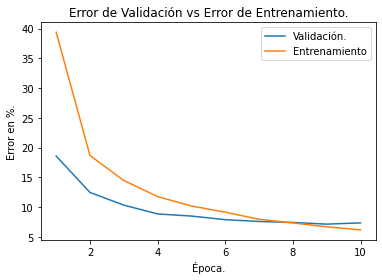

In [24]:
epocas = range(1,len(E_V_ReLU)+1)

plt.plot(epocas, E_V_ReLU, label="Validación.")
plt.plot(epocas, E_E_ReLU, label="Entrenamiento")
plt.title("Error de Validación vs Error de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

**Observaciones:**

Se puede ver claramente que los errores en ambos conjuntos son muy parecidos, a diferencia de la gráfica del notebook "RN_Comparacion_FAs" para esta configuración, en donde claramente el error de validación es mayor que el de entrenamiento. Esto se traduce en una mejora en la capacidad de generalización por parte de nuestro modelo.

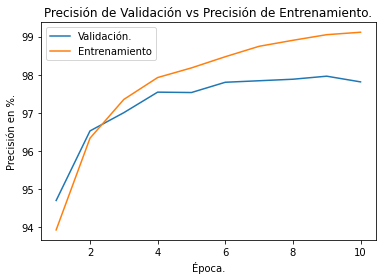

In [26]:
epocas = range(1,len(P_V_ReLU)+1)

plt.plot(epocas, P_V_ReLU, label="Validación.")
plt.plot(epocas, P_E_ReLU, label="Entrenamiento")
plt.title("Precisión de Validación vs Precisión de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Precisión en %.")
plt.legend()

**Observaciones:**

Esta gráfica es muy parecida a la gráfica de la precisión en el notebook "RN_Comparacion_FAs", para esta configuración. Sin embargo, el porcentaje de precisión sobre los datos de entrenamiento para esta gráfica es de $99.116\%$, mientras que para su homónima en el notebook antes mencionado es de $99.67\%$, lo que se traduce en una menor memorización (aunque sea mínima), por parte de este modelo. Para esto es que sirven las regularización, para contrarestar el overfitting y aumentar la capacidad de generalización de una red.

**L2:**

In [247]:
epocas = 10
tamaño_lote = 200

Pesos_ReLU_L2, Bias_ReLU_L2, E_E_ReLU_L2, E_V_ReLU_L2, P_E_ReLU_L2, P_V_ReLU_L2, FA_CO_ReLU_L2 = \
algoritmo_entrenamiento(Datos_Entrenamiento, Etiquetas_Entrenamiento, epocas, tamaño_lote, Datos_Validacion, Etiquetas_Validacion)


Por default, tienes una sola capa de entrada. Por lo tanto...


Cuantas capas ocultas deseas?:  1


Finalmente y por default, tienes una sola capa de salida.

'Tu Red Neuronal cuenta con 1 Capa de Entrada, 1 Capas Ocultas y 1 Capa de Salida'.

'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,
el programa selecciona de manera automática el número de neuronas de entrada por tí'.



Cuántas neuronas deseas para la capa oculta 1:  512
Cuántas neuronas deseas para la capa de salida:  10

Qué valor deseas para la tasa de aprendizaje:  0.98

Qué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) 0
Qué tipo de regularización deseas? Ninguno (0), Dropout(1) o L2 (2) 2
Ingresa el valor de lambda: 0 < lambda < 1 0.001



La cantidad de lotes a ingresar a la red es: 250.0.

Época: 1
Precisión en los Datos de Validación: 93.28999999999999%
Error en los Datos de Validación: 22.491526642763574%
Precisión en los Datos de Entrenamiento: 92.71000000000001%
Error Total de la Red sobre los Datos de Entrenamiento: 90.291974994%

Época: 2
Precisión en los Datos de Validación: 94.3%
Error en los Datos de Validación: 19.50597953397098%
Precisión en los Datos de Entrenamiento: 93.87%
Error Total de la Red sobre los Datos de Entrenamiento: 45.6262490129%

Época: 3
Precisión en los Datos de Validación: 94.66%
Error en los Datos de Validación: 18.19468792185194%
Precisión en los Datos de Entrenamiento: 94.464%
Error Total de la Red sobre los Datos de Entrenamiento: 34.5043711981%

Época: 4
Precisión en los Datos de Validación: 94.89%
Error en los Datos de Validación: 17.456354103242404%
Precisión en los Datos de Entrenamiento: 94.758%
Error Total de la Red sobre los Datos de Entrenamiento: 30.3269449598%

Época: 5
Pre

In [248]:
Predicciones_Testeo_ReLU_L2, Error_Testeo_ReLU_L2 = Predicciones(Pesos_ReLU_L2, Bias_ReLU_L2, imagenes_testeo, etiquetas_testeo_ONE_HOT, 
                                                          FA_CO_ReLU_L2)

In [249]:
print(f"Error sobre los datos de Testeo: {np.around(Error_Testeo_ReLU_L2, decimals=4)}%.")

Aciertos_Testeo_ReLU_L2 = (Predicciones_Testeo_ReLU_L2 == etiquetas_testeo).sum()
print(f"Cantidad de Aciertos sobre el conjunto de Testeo: {Aciertos_Testeo_ReLU_L2}")

P_T_ReLU_L2 = (Aciertos_Testeo_ReLU_L2 / len(etiquetas_testeo))*100
print(f"Porcentaje de Precisión sobre los datos de Testeo: {P_T_ReLU_L2}%")

Error sobre los datos de Testeo: 16.7576%.
Cantidad de Aciertos sobre el conjunto de Testeo: 9510
Porcentaje de Precisión sobre los datos de Testeo: 95.1%


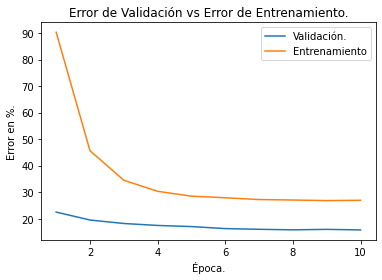

In [250]:
epocas = range(1,len(E_V_ReLU_L2)+1)

plt.plot(epocas, E_V_ReLU_L2, label="Validación.")
plt.plot(epocas, E_E_ReLU_L2, label="Entrenamiento")
plt.title("Error de Validación vs Error de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

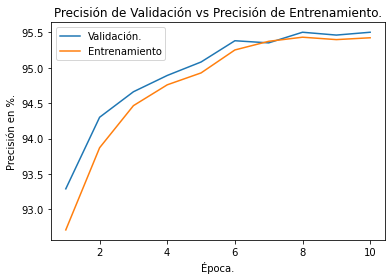

In [251]:
epocas = range(1,len(P_V_ReLU_L2)+1)

plt.plot(epocas, P_V_ReLU_L2, label="Validación.")
plt.plot(epocas, P_E_ReLU_L2, label="Entrenamiento")
plt.title("Precisión de Validación vs Precisión de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Precisión en %.")
plt.legend()

**Observaciones:**

Como podemos notar, los resultados son buenos. No obstante, la regularización usando Dropout proporciono una mayor precisión sobre los datos teste, que, recordemos, son los veradaderamente importantes.

***

#### **PARA LEAKY RELU**

**DROPOUT:**

In [252]:
epocas = 10
tamaño_lote = 200

Pesos_Leaky_ReLU, Bias_Leaky_ReLU, E_E_Leaky_ReLU, E_V_Leaky_ReLU, P_E_Leaky_ReLU, P_V_Leaky_ReLU, FA_CO_Leaky_ReLU = \
algoritmo_entrenamiento(Datos_Entrenamiento, Etiquetas_Entrenamiento, epocas, tamaño_lote, Datos_Validacion, Etiquetas_Validacion)


Por default, tienes una sola capa de entrada. Por lo tanto...


Cuantas capas ocultas deseas?:  1


Finalmente y por default, tienes una sola capa de salida.

'Tu Red Neuronal cuenta con 1 Capa de Entrada, 1 Capas Ocultas y 1 Capa de Salida'.

'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,
el programa selecciona de manera automática el número de neuronas de entrada por tí'.



Cuántas neuronas deseas para la capa oculta 1:  512
Cuántas neuronas deseas para la capa de salida:  10

Qué valor deseas para la tasa de aprendizaje:  0.98

Qué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) 1
Qué tipo de regularización deseas? Ninguno (0), Dropout(1) o L2 (2) 1



La cantidad de lotes a ingresar a la red es: 250.0.

Época: 1
Precisión en los Datos de Validación: 95.02000000000001%
Error en los Datos de Validación: 18.00801075484019%
Precisión en los Datos de Entrenamiento: 94.44%
Error Total de la Red sobre los Datos de Entrenamiento: 39.5631278952%

Época: 2
Precisión en los Datos de Validación: 96.39%
Error en los Datos de Validación: 12.252733379077425%
Precisión en los Datos de Entrenamiento: 96.476%
Error Total de la Red sobre los Datos de Entrenamiento: 18.4699775787%

Época: 3
Precisión en los Datos de Validación: 97.08%
Error en los Datos de Validación: 10.179141183588749%
Precisión en los Datos de Entrenamiento: 97.384%
Error Total de la Red sobre los Datos de Entrenamiento: 14.4214983969%

Época: 4
Precisión en los Datos de Validación: 97.22%
Error en los Datos de Validación: 9.14623232937974%
Precisión en los Datos de Entrenamiento: 97.898%
Error Total de la Red sobre los Datos de Entrenamiento: 11.8860882837%

Época: 5
Precisión en 

In [253]:
Predicciones_Testeo_Leaky_ReLU, Error_Testeo_Leaky_ReLU = Predicciones(Pesos_Leaky_ReLU, Bias_Leaky_ReLU, imagenes_testeo, etiquetas_testeo_ONE_HOT, 
                                                          FA_CO_Leaky_ReLU)

In [254]:
print(f"Error sobre los datos de Testeo: {np.around(Error_Testeo_Leaky_ReLU, decimals=4)}%.")

Aciertos_Testeo_Leaky_ReLU = (Predicciones_Testeo_Leaky_ReLU == etiquetas_testeo).sum()
print(f"Cantidad de Aciertos sobre el conjunto de Testeo: {Aciertos_Testeo_Leaky_ReLU}")

P_T_Leaky_ReLU = (Aciertos_Testeo_Leaky_ReLU / len(etiquetas_testeo))*100
print(f"Porcentaje de Precisión sobre los datos de Testeo: {P_T_Leaky_ReLU}%")

Error sobre los datos de Testeo: 6.6872%.
Cantidad de Aciertos sobre el conjunto de Testeo: 9803
Porcentaje de Precisión sobre los datos de Testeo: 98.03%


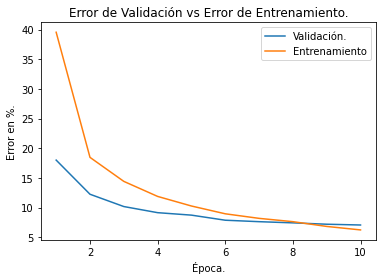

In [255]:
epocas = range(1,len(E_V_Leaky_ReLU)+1)

plt.plot(epocas, E_V_Leaky_ReLU, label="Validación.")
plt.plot(epocas, E_E_Leaky_ReLU, label="Entrenamiento")
plt.title("Error de Validación vs Error de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

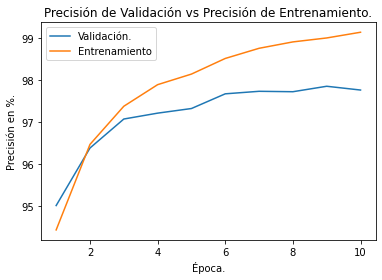

In [256]:
epocas = range(1,len(P_V_Leaky_ReLU)+1)

plt.plot(epocas, P_V_Leaky_ReLU, label="Validación.")
plt.plot(epocas, P_E_Leaky_ReLU, label="Entrenamiento")
plt.title("Precisión de Validación vs Precisión de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Precisión en %.")
plt.legend()

**L2:**

In [273]:
epocas = 10
tamaño_lote = 200

Pesos_Leaky_ReLU, Bias_Leaky_ReLU, E_E_Leaky_ReLU, E_V_Leaky_ReLU, P_E_Leaky_ReLU, P_V_Leaky_ReLU, FA_CO_Leaky_ReLU = \
algoritmo_entrenamiento(Datos_Entrenamiento, Etiquetas_Entrenamiento, epocas, tamaño_lote, Datos_Validacion, Etiquetas_Validacion)


Por default, tienes una sola capa de entrada. Por lo tanto...


Cuantas capas ocultas deseas?:  1


Finalmente y por default, tienes una sola capa de salida.

'Tu Red Neuronal cuenta con 1 Capa de Entrada, 1 Capas Ocultas y 1 Capa de Salida'.

'El número de neuronas de entrada esta determinado por el número de componentes de tu vector de entrada, por lo tanto,
el programa selecciona de manera automática el número de neuronas de entrada por tí'.



Cuántas neuronas deseas para la capa oculta 1:  512
Cuántas neuronas deseas para la capa de salida:  10

Qué valor deseas para la tasa de aprendizaje:  0.98

Qué función de activación deseas para las capas ocultas: ReLU (0) ; Leaky_ReLU (1) 1
Qué tipo de regularización deseas? Ninguno (0), Dropout(1) o L2 (2) 2
Ingresa el valor de lambda: 0 < lambda < 1 0.001



La cantidad de lotes a ingresar a la red es: 250.0.

Época: 1
Precisión en los Datos de Validación: 92.99%
Error en los Datos de Validación: 22.915242706678715%
Precisión en los Datos de Entrenamiento: 92.532%
Error Total de la Red sobre los Datos de Entrenamiento: 89.2384301228%

Época: 2
Precisión en los Datos de Validación: 94.59%
Error en los Datos de Validación: 18.82153386088056%
Precisión en los Datos de Entrenamiento: 94.134%
Error Total de la Red sobre los Datos de Entrenamiento: 45.6377161348%

Época: 3
Precisión en los Datos de Validación: 94.99%
Error en los Datos de Validación: 17.595616826368516%
Precisión en los Datos de Entrenamiento: 94.594%
Error Total de la Red sobre los Datos de Entrenamiento: 34.6812453597%

Época: 4
Precisión en los Datos de Validación: 95.04%
Error en los Datos de Validación: 17.0090561473412%
Precisión en los Datos de Entrenamiento: 94.77600000000001%
Error Total de la Red sobre los Datos de Entrenamiento: 30.7570377781%

Época: 5
Precisión en 

In [274]:
Predicciones_Testeo_Leaky_ReLU, Error_Testeo_Leaky_ReLU = Predicciones(Pesos_Leaky_ReLU, Bias_Leaky_ReLU, imagenes_testeo, etiquetas_testeo_ONE_HOT, 
                                                          FA_CO_Leaky_ReLU)

In [275]:
print(f"Error sobre los datos de Testeo: {np.around(Error_Testeo_Leaky_ReLU, decimals=4)}%.")

Aciertos_Testeo_Leaky_ReLU = (Predicciones_Testeo_Leaky_ReLU == etiquetas_testeo).sum()
print(f"Cantidad de Aciertos sobre el conjunto de Testeo: {Aciertos_Testeo_Leaky_ReLU}")

P_T_Leaky_ReLU = (Aciertos_Testeo_Leaky_ReLU / len(etiquetas_testeo))*100
print(f"Porcentaje de Precisión sobre los datos de Testeo: {P_T_Leaky_ReLU}%")

Error sobre los datos de Testeo: 17.4602%.
Cantidad de Aciertos sobre el conjunto de Testeo: 9486
Porcentaje de Precisión sobre los datos de Testeo: 94.86%


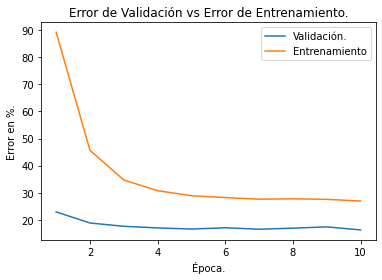

In [276]:
epocas = range(1,len(E_V_Leaky_ReLU)+1)

plt.plot(epocas, E_V_Leaky_ReLU, label="Validación.")
plt.plot(epocas, E_E_Leaky_ReLU, label="Entrenamiento")
plt.title("Error de Validación vs Error de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Error en %.")
plt.legend()

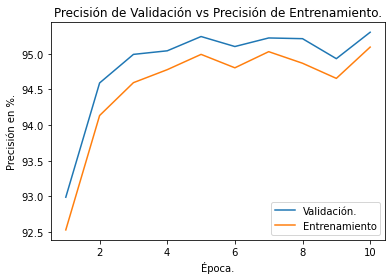

In [277]:
epocas = range(1,len(P_V_Leaky_ReLU)+1)

plt.plot(epocas, P_V_Leaky_ReLU, label="Validación.")
plt.plot(epocas, P_E_Leaky_ReLU, label="Entrenamiento")
plt.title("Precisión de Validación vs Precisión de Entrenamiento.")
plt.xlabel("Época.")
plt.ylabel("Precisión en %.")
plt.legend()

**Observaciones:**

Al igual que con **ReLU**, la regularización con **Dropout** sigue arrojando mejores resultados.

**CONCLUSIÓN GENERAL:**

Realizar dos modelos, uno **sin regularización** y otro con regularización **Dropout**, y **seleccionar el que nos otorgue una mayor precisión en los datos de testeo.**